In [1]:
""" 
Purpose: To plot a wide range of the receptive field correlations to make sure they are acceptable

Plan for whole notebook
1) develop a function that will plot out the receptive field with the title of ids and the correlation
2) Go through and divide up the whole range of RF correlations into certain intervals
3) Sample X number of ID pairs from each of those groups and plot each one of them
"""

' \nPurpose: To plot a wide range of the receptive field correlations to make sure they are acceptable\n\nPlan for whole notebook\n1) develop a function that will plot out the receptive field with the title of ids and the correlation\n2) Go through and divide up the whole range of RF correlations into certain intervals\n3) Sample X number of ID pairs from each of those groups and plot each one of them\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from funconnect import morphology, connectomics, ta3, nda
from tqdm import tqdm
import scipy.stats as stats


Connecting celiib@10.28.0.34:3306


In [3]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20


pinky = dj.create_virtual_module('pinky', 'microns_pinky')
pinky_nda = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')


In [4]:
synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation
segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = soma & "cell_class='excitatory'"

In [5]:
# part that will calculate the difference in orientation and receptive field correlation and put into pandas table
"""
WHERE THE RF CORRELATION BINS ARE EXPLICITELY SET
"""

attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.50'

cbin_edges = np.linspace(-.7, .7, 6) #setting the bin boundaries
#calculates the centers of the bins used for the receptive field
cbin_centers = np.hstack((np.nan, np.round((cbin_edges[1:] + cbin_edges[:-1])/2, decimals=2), np.nan))
#creates labels for the receptive field edges
cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(cbin_edges[:-1], cbin_edges[1:])]
cbin_labels
"""
Calculate the bins and centers for the orientational preference
"""
#defines how to find the "tuned" segments of the orientation
dori_resolution = np.pi / 2 / 4 #setting the width size of the bins to be 22.5 degrees
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9) #creates 8 bins between boundaries between 0 and pi

# turns all of the bin edges into degrees with no decimal
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in bin_edges]])
#creates the bin boundary markings with [low - high]
bin_labels = list(zip(be[:-1], be[1:]))

#calculates the bin centers
bin_centers = np.round((bin_edges[1:] + bin_edges[:-1])/2 * rad2deg, decimals=2) 


"""
Gets the segments with the acceptable rf thresholds
"""

# functional metrics for each functional soma pair (restricting by spattune fitting significance)

sig_units_rf = spattune.BestSTA.Loc & 'sta_snr > 1.50' & segment
sig_unit_pairs_rf = (sig_units_rf.proj(segment_id1 = 'segment_id') * 
                  sig_units_rf.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

sig_units_rf
# attrs_rf = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
# spatconn_df_rf = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs_rf) * fc.SharedInput.proj(*attrs_rf, segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())
# spatconn_df_rf


"""gets table where have every connection from segment_a to segment b anf the number of n_seg_shared stacked on a 
repeat but the ids for a and b are switched  """
shi = fc.SharedInput.proj("n_seg_shared",segment_a="segment_id")
shi

#check that have neurons from both orphans and excitatory
len(shi & pinky.Decimation35Orphan.proj(segment_a="segment_id")),len(shi & pinky.PymeshfixDecimatedExcitatoryStitchedMesh.proj(segment_a="segment_id"))



rf_table = (spattune.BestSTACorr.proj(rf_corr_coef="union_corr_r2",
                          segment_a="segment_id1",segment_b="segment_id2")
                          & sig_units_rf.proj(segment_a="segment_id") &
                          sig_units_rf.proj(segment_b="segment_id"))
rf_table


"""
build the pref_rel table to use for the orinetation data

This table just needs the 
1) segment_id
2) von_r2 (orientation preference)
--> for all of the tuned segments
"""
tuned = 'confidence > 0.5'
#get the significantly tuned segments
sig_units_op = radtune.BestVonFit.Unit & 'von_p_value <= 0.05' & tuned & segment
sig_units_op
# sig_unit_pairs_op = (sig_units_op.proj(segment_id1 = 'segment_id') * 
#                  sig_units_op.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'


#gets the significantly tuned neurons and their differences in combinational pairs 
sig_unit_pairs_op = (radtune.BestVonCorr() & sig_units_op.proj(segment_id1="segment_id") 
                 & sig_units_op.proj(segment_id2="segment_id")).proj("diff_pref_ori")

sig_unit_pairs_op = sig_unit_pairs_op.proj(segment_a="segment_id1",
                                           segment_b="segment_id2",
                                           dori="diff_pref_ori")
sig_unit_pairs_op


significant_contacts = 10
#sig_cont= dict(n_seg_shared=significant_contacts)
sign_contact_correlations = fc.ContactCorrelation.proj("n_seg_shared") & "n_seg_shared>"+ str(significant_contacts)
sign_contact_correlations

len(shi),len(shi & sign_contact_correlations.proj(segment_a="segment_id"))
new_shi = shi & sign_contact_correlations.proj(segment_a="segment_id")



""" takes all of the possible shared input combinations:
1) gets this correlation table and renames seg a and b and uses that to restrict the shared input combinations and attach the rf correlation
2) Further restricts to only those TUNED with prefered orientation (and adds on the orientation for a and b)
3) Restrict to only significant rective fields for both segment A and B by DOES NOT ATTACH THE RF score

"""

crel = shi * rf_table * sig_unit_pairs_op
new_crel =  new_shi * rf_table * sig_unit_pairs_op
len(crel),len(new_crel)

crel = new_crel
cdf = pd.DataFrame(crel.fetch())

#gets the bins of the correlations of the receptive fields
cdf['bcorr'] = cbin_centers[(np.digitize(cdf['rf_corr_coef'], cbin_edges))]
#makes the number of shared segments as floats
cdf['n_seg_shared'] = np.array(cdf['n_seg_shared']).astype(float)
#makes the bins of the corelation of the receptive fields as floats
cdf['bcorr'] = np.array(cdf['bcorr']).astype(float)
cdf

cdf['bdori'] = bin_centers[(np.digitize(np.abs(cdf["dori"]), bin_edges))-1]

# helps find the binned distribution of the ranges

In [6]:
"""
Makes the bins to be sampled from 
"""

n_boundaries = 11

#getting the data values
rf_correlation = cdf["rf_corr_coef"].values
ori_difference = cdf["dori"].values
ori_difference

ori_bin_edges = [np.percentile(ori_difference,x) for x in list(np.linspace(0,95,n_boundaries)) ]

# ori_bin_edges = [np.min(np.abs(ori_difference)),
#      np.percentile(np.abs(ori_difference),25),
#      np.percentile(np.abs(ori_difference),50),
#      np.percentile(np.abs(ori_difference),75),
#      np.max(np.abs(ori_difference))]
#get the midpoints of each
ori_bin_midpoints = np.round([np.mean(ori_bin_edges[i:i+2]) for i in range(0,len(ori_bin_edges)-1)],2)
ori_bin_midpoints_angles = np.round((ori_bin_midpoints)*180/np.pi,2)
print(ori_bin_edges)
print(ori_bin_midpoints_angles)

rf_bin_edges = [np.percentile(rf_correlation,x) for x in list(np.linspace(0,95,n_boundaries)) ]

# rf_bin_edges = [np.min(rf_correlation),
#      np.percentile(rf_correlation,25),
#      np.percentile(rf_correlation,50),
#      np.percentile(rf_correlation,75),
#      np.max(rf_correlation)]

rf_bin_midpoints = np.round([np.mean(rf_bin_edges[i:i+2]) for i in range(0,len(rf_bin_edges)-1)],2)
print(rf_bin_edges)
print(rf_bin_midpoints)


# #now add new columns that bin the groups according to thsoe edges
# cdf["bcorr_2"] = rf_bin_midpoints[np.digitize(cdf["rf_corr_coef"].values,rf_bin_edges,right=True)-1]
# cdf["bdori_2"] = ori_bin_midpoints_angles[np.digitize(np.abs(cdf["dori"].values),ori_bin_edges,right=True)-1]


[-1.51144, -1.1861407000000002, -0.59797142, -0.37590832999999996, -0.25090056, -0.08889594500000003, 0.024205145999999955, 0.25695403, 0.5995670399999996, 0.9674945100000002, 1.360365]
[-77.35 -50.99 -28.07 -17.76  -9.74  -1.72   8.02  24.64  44.69  66.46]
[-0.71872, -0.47781703000000003, -0.35397091999999997, -0.19221494000000003, -0.08901211200000003, 0.015529189999999981, 0.07682135999999999, 0.24888916, 0.39331176, 0.5556412400000004, 0.8290673999999999]
[-0.6  -0.42 -0.27 -0.14 -0.04  0.05  0.16  0.32  0.47  0.69]


In [7]:
def display_rf_field_groups(seg_group,title=""):
    
    group_size = len(seg_group)
    from itertools import chain
    gs = plt.GridSpec(group_size, 2) #specifies geometry of a grid that subplot can be placed on 
    fig = plt.figure(figsize=(7,7.5)) #defines size of the figure
    #ax_heat = fig.add_subplot(gs[:,1:3]) #blocks off the middle two columns for the heat map
    ax_list = []
    with sns.axes_style('whitegrid'):
        for k in range(0,group_size):
            ax_list.append(fig.add_subplot(gs[k,0]))
            ax_list.append(fig.add_subplot(gs[k,1]))





    rf_list = []
    rf_group = [[rf for rf in (spattune.BestSTA.Map & 'segment_id in ' + str(tuple(k))).fetch('sta')] for k in seg_group]
    for rf in rf_group:
        rf_list.append(rf[0])
        rf_list.append(rf[1])

    plt.title(title)
    for tl, rf in zip(ax_list,rf_list):
        #print(rf.shape)
        #rf -= rf.mean()
        v = np.abs(rf).max()
    #     tl.contour(rf, cmap='bwr', levels=np.linspace(-v,v,7))
        tl.matshow(rf, cmap='bwr', vmin=-v, vmax=v) #
        tl.set_xticklabels([])
        tl.set_yticklabels([])
        tl.tick_params(axis='both', length=0, width=0)
    
    plt.show()
    

******


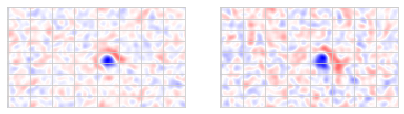

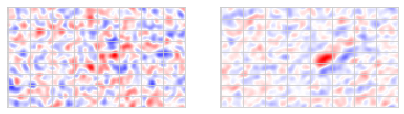

In [8]:
print("******")
display_rf_field_groups(seg_group=[(648518346341366913,648518346349513012)])
display_rf_field_groups(seg_group=[(648518346341374333,648518346349510900)])

In [9]:
# """
# Practice restricting the pandas table and extracting X number of the segment ID pairs

# """

# sample_per_bin = 3

# ori_index = 2
# rf_index = 3

# ori_min_max = (ori_bin_edges[ori_index],ori_bin_edges[ori_index+1])
# print(ori_min_max)
# rf_min_max = (rf_bin_edges[rf_index],rf_bin_edges[rf_index+1])
# print(rf_min_max)

# #restrict table by these values
# temp_cdf = cdf[(cdf.dori >ori_min_max[0] ) & (cdf.dori < ori_min_max[1] ) 
#     & (cdf.rf_corr_coef >rf_min_max[0] ) & (cdf.rf_corr_coef < rf_min_max[1] )]

# if len(temp_cdf["segment_a"].values)>= sample_per_bin:
#     segment_a_values = temp_cdf["segment_a"].values[:sample_per_bin]
#     segment_b_values = temp_cdf["segment_b"].values[:sample_per_bin]
# else: 
    
#     segment_a_values = temp_cdf["segment_a"].values
#     segment_b_values = temp_cdf["segment_b"].values
#     print("list was too samll so doing the length of the list which is " + str(len(segment_a_values)))
    
# print(list(zip(segment_a_values,segment_b_values)))
# temp_cdf

***** Group 1: ori range = [-1.511 -1.186], rf range = [-0.719 -0.478]
list was too samll so doing the length of the list which is 1


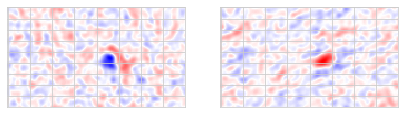

***** Group 2: ori range = [-1.511 -1.186], rf range = [-0.478 -0.354]


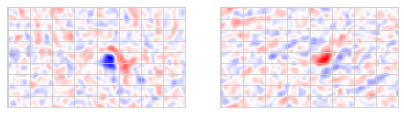

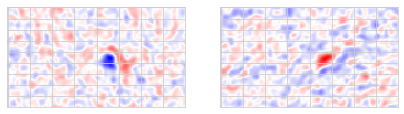

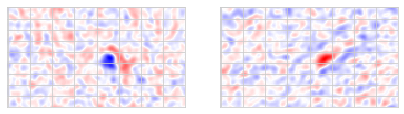

***** Group 3: ori range = [-1.511 -1.186], rf range = [-0.354 -0.192]
list was too samll so doing the length of the list which is 1


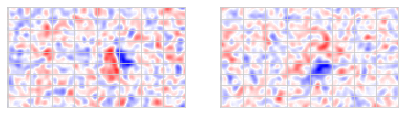

***** Group 4: ori range = [-1.511 -1.186], rf range = [-0.192 -0.089]
list was too samll so doing the length of the list which is 0
***** Group 5: ori range = [-1.511 -1.186], rf range = [-0.089  0.016]
list was too samll so doing the length of the list which is 1


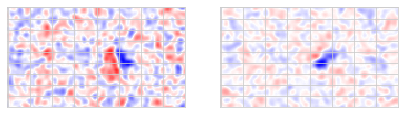

***** Group 6: ori range = [-1.511 -1.186], rf range = [0.016 0.077]
list was too samll so doing the length of the list which is 2


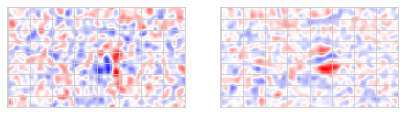

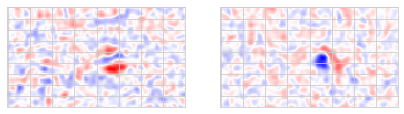

***** Group 7: ori range = [-1.511 -1.186], rf range = [0.077 0.249]
list was too samll so doing the length of the list which is 1


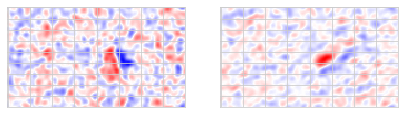

***** Group 8: ori range = [-1.511 -1.186], rf range = [0.249 0.393]
list was too samll so doing the length of the list which is 2


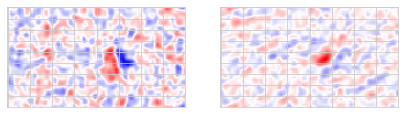

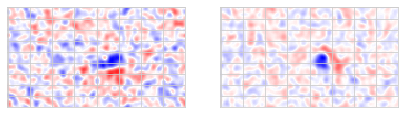

***** Group 9: ori range = [-1.511 -1.186], rf range = [0.393 0.556]
list was too samll so doing the length of the list which is 2


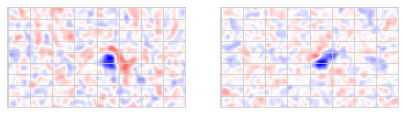

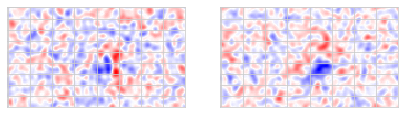

***** Group 10: ori range = [-1.511 -1.186], rf range = [0.556 0.829]
list was too samll so doing the length of the list which is 1


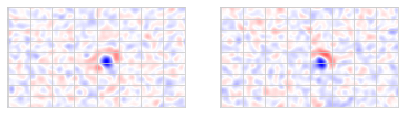

***** Group 11: ori range = [-1.186 -0.598], rf range = [-0.719 -0.478]
list was too samll so doing the length of the list which is 0
***** Group 12: ori range = [-1.186 -0.598], rf range = [-0.478 -0.354]
list was too samll so doing the length of the list which is 0
***** Group 13: ori range = [-1.186 -0.598], rf range = [-0.354 -0.192]
list was too samll so doing the length of the list which is 1


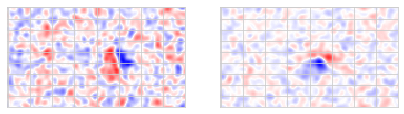

***** Group 14: ori range = [-1.186 -0.598], rf range = [-0.192 -0.089]


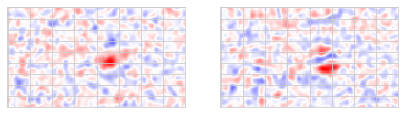

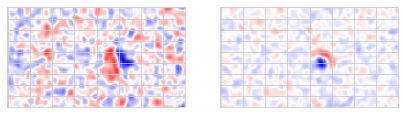

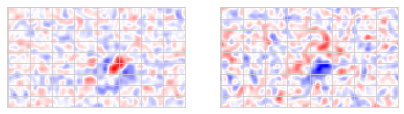

***** Group 15: ori range = [-1.186 -0.598], rf range = [-0.089  0.016]
list was too samll so doing the length of the list which is 1


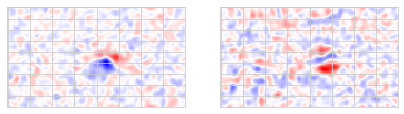

***** Group 16: ori range = [-1.186 -0.598], rf range = [0.016 0.077]
list was too samll so doing the length of the list which is 2


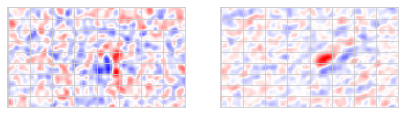

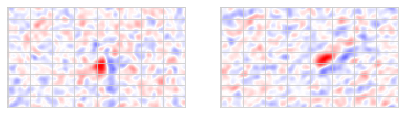

***** Group 17: ori range = [-1.186 -0.598], rf range = [0.077 0.249]


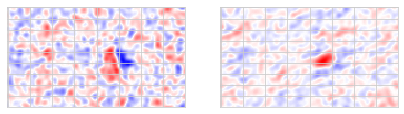

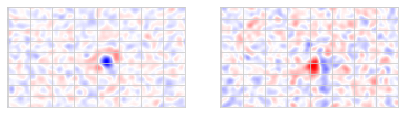

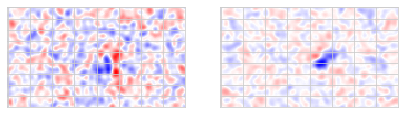

***** Group 18: ori range = [-1.186 -0.598], rf range = [0.249 0.393]
list was too samll so doing the length of the list which is 1


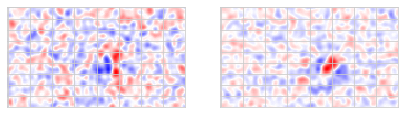

***** Group 19: ori range = [-1.186 -0.598], rf range = [0.393 0.556]


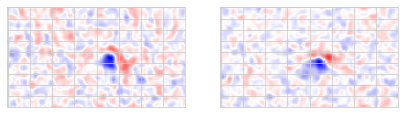

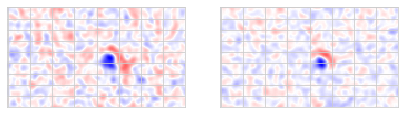

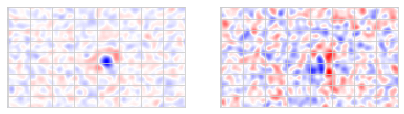

***** Group 20: ori range = [-1.186 -0.598], rf range = [0.556 0.829]
list was too samll so doing the length of the list which is 0
***** Group 21: ori range = [-0.598 -0.376], rf range = [-0.719 -0.478]
list was too samll so doing the length of the list which is 1


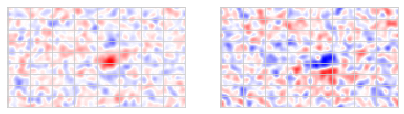

***** Group 22: ori range = [-0.598 -0.376], rf range = [-0.478 -0.354]
list was too samll so doing the length of the list which is 1


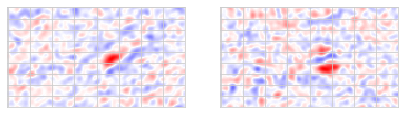

***** Group 23: ori range = [-0.598 -0.376], rf range = [-0.354 -0.192]


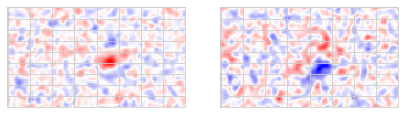

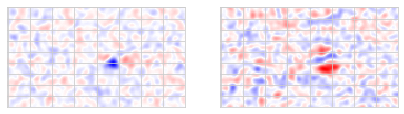

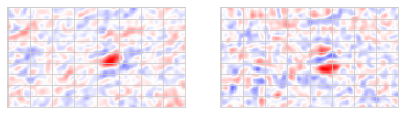

***** Group 24: ori range = [-0.598 -0.376], rf range = [-0.192 -0.089]
list was too samll so doing the length of the list which is 2


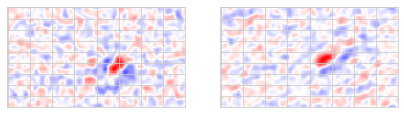

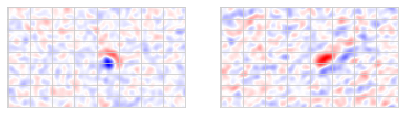

***** Group 25: ori range = [-0.598 -0.376], rf range = [-0.089  0.016]
list was too samll so doing the length of the list which is 2


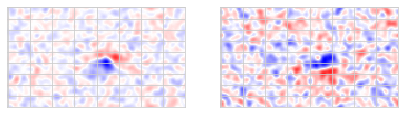

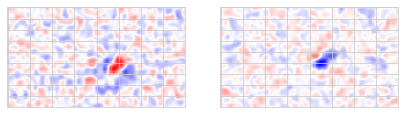

***** Group 26: ori range = [-0.598 -0.376], rf range = [0.016 0.077]
list was too samll so doing the length of the list which is 0
***** Group 27: ori range = [-0.598 -0.376], rf range = [0.077 0.249]
list was too samll so doing the length of the list which is 1


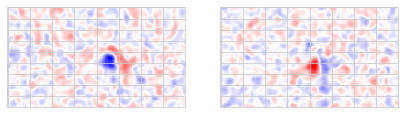

***** Group 28: ori range = [-0.598 -0.376], rf range = [0.249 0.393]
list was too samll so doing the length of the list which is 1


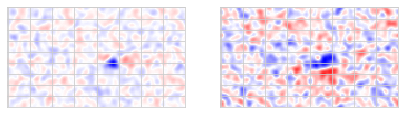

***** Group 29: ori range = [-0.598 -0.376], rf range = [0.393 0.556]
list was too samll so doing the length of the list which is 0
***** Group 30: ori range = [-0.598 -0.376], rf range = [0.556 0.829]


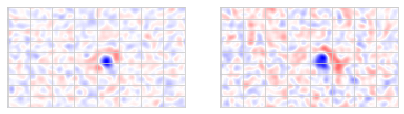

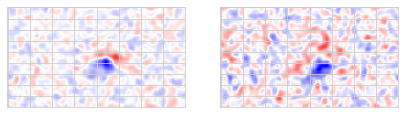

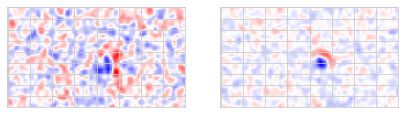

***** Group 31: ori range = [-0.376 -0.251], rf range = [-0.719 -0.478]


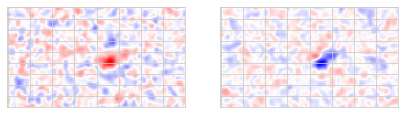

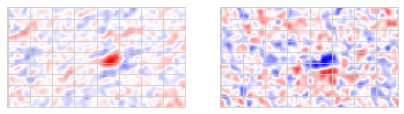

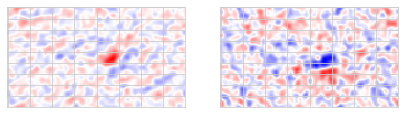

***** Group 32: ori range = [-0.376 -0.251], rf range = [-0.478 -0.354]
list was too samll so doing the length of the list which is 0
***** Group 33: ori range = [-0.376 -0.251], rf range = [-0.354 -0.192]
list was too samll so doing the length of the list which is 0
***** Group 34: ori range = [-0.376 -0.251], rf range = [-0.192 -0.089]
list was too samll so doing the length of the list which is 2


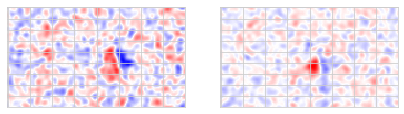

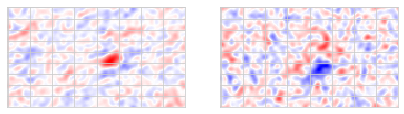

***** Group 35: ori range = [-0.376 -0.251], rf range = [-0.089  0.016]
list was too samll so doing the length of the list which is 2


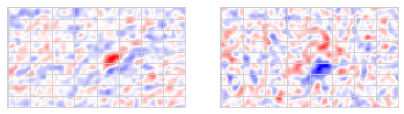

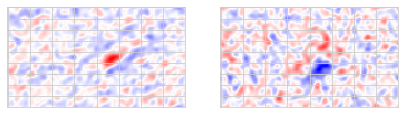

***** Group 36: ori range = [-0.376 -0.251], rf range = [0.016 0.077]
list was too samll so doing the length of the list which is 1


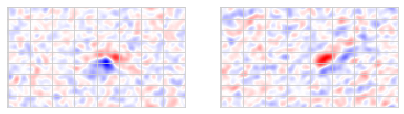

***** Group 37: ori range = [-0.376 -0.251], rf range = [0.077 0.249]


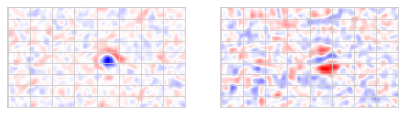

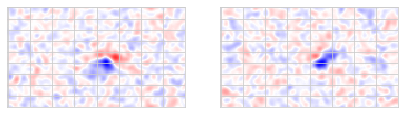

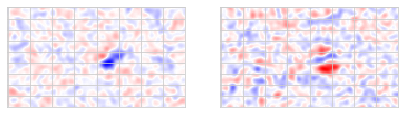

***** Group 38: ori range = [-0.376 -0.251], rf range = [0.249 0.393]
list was too samll so doing the length of the list which is 0
***** Group 39: ori range = [-0.376 -0.251], rf range = [0.393 0.556]
list was too samll so doing the length of the list which is 1


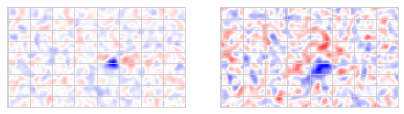

***** Group 40: ori range = [-0.376 -0.251], rf range = [0.556 0.829]


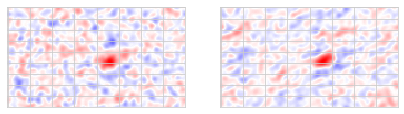

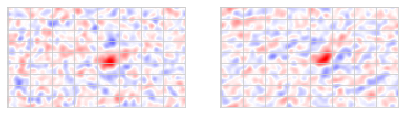

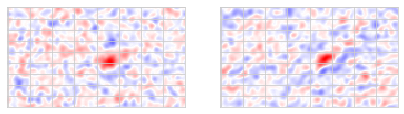

***** Group 41: ori range = [-0.251 -0.089], rf range = [-0.719 -0.478]
list was too samll so doing the length of the list which is 0
***** Group 42: ori range = [-0.251 -0.089], rf range = [-0.478 -0.354]
list was too samll so doing the length of the list which is 2


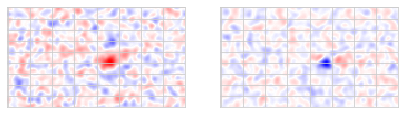

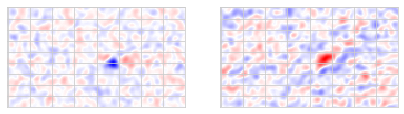

***** Group 43: ori range = [-0.251 -0.089], rf range = [-0.354 -0.192]


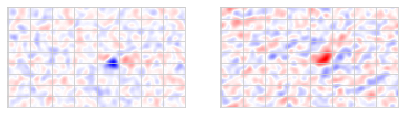

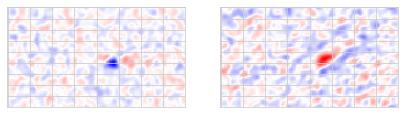

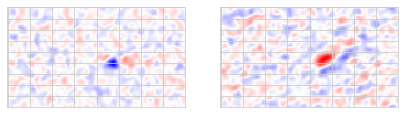

***** Group 44: ori range = [-0.251 -0.089], rf range = [-0.192 -0.089]
list was too samll so doing the length of the list which is 0
***** Group 45: ori range = [-0.251 -0.089], rf range = [-0.089  0.016]
list was too samll so doing the length of the list which is 1


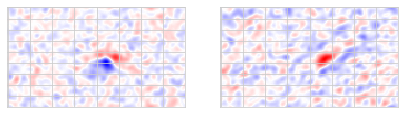

***** Group 46: ori range = [-0.251 -0.089], rf range = [0.016 0.077]
list was too samll so doing the length of the list which is 2


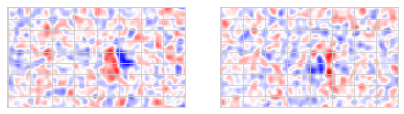

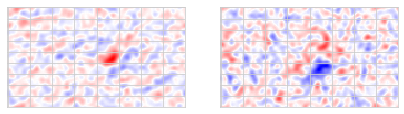

***** Group 47: ori range = [-0.251 -0.089], rf range = [0.077 0.249]
list was too samll so doing the length of the list which is 1


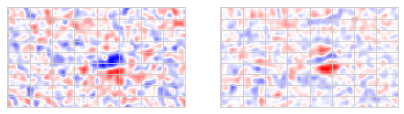

***** Group 48: ori range = [-0.251 -0.089], rf range = [0.249 0.393]
list was too samll so doing the length of the list which is 1


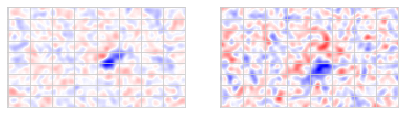

***** Group 49: ori range = [-0.251 -0.089], rf range = [0.393 0.556]
list was too samll so doing the length of the list which is 2


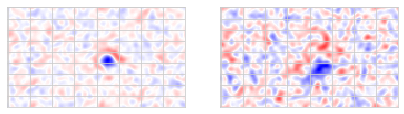

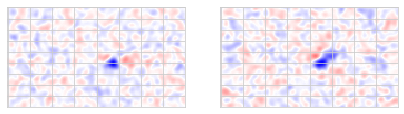

***** Group 50: ori range = [-0.251 -0.089], rf range = [0.556 0.829]
list was too samll so doing the length of the list which is 0
***** Group 51: ori range = [-0.089  0.024], rf range = [-0.719 -0.478]


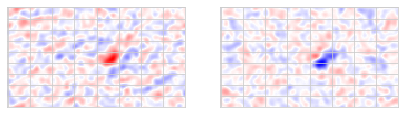

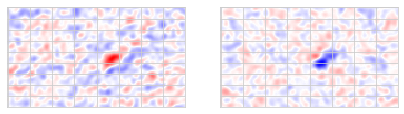

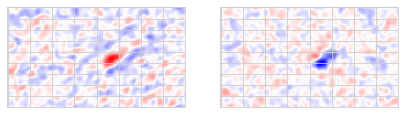

***** Group 52: ori range = [-0.089  0.024], rf range = [-0.478 -0.354]
list was too samll so doing the length of the list which is 1


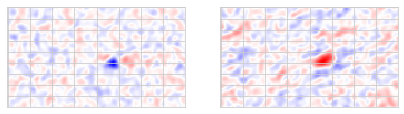

***** Group 53: ori range = [-0.089  0.024], rf range = [-0.354 -0.192]
list was too samll so doing the length of the list which is 0
***** Group 54: ori range = [-0.089  0.024], rf range = [-0.192 -0.089]
list was too samll so doing the length of the list which is 1


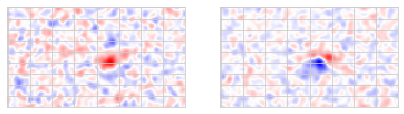

***** Group 55: ori range = [-0.089  0.024], rf range = [-0.089  0.016]
list was too samll so doing the length of the list which is 1


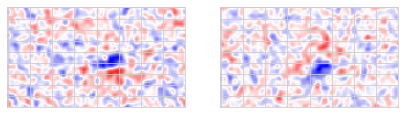

***** Group 56: ori range = [-0.089  0.024], rf range = [0.016 0.077]
list was too samll so doing the length of the list which is 0
***** Group 57: ori range = [-0.089  0.024], rf range = [0.077 0.249]
list was too samll so doing the length of the list which is 0
***** Group 58: ori range = [-0.089  0.024], rf range = [0.249 0.393]
list was too samll so doing the length of the list which is 0
***** Group 59: ori range = [-0.089  0.024], rf range = [0.393 0.556]
list was too samll so doing the length of the list which is 0
***** Group 60: ori range = [-0.089  0.024], rf range = [0.556 0.829]
list was too samll so doing the length of the list which is 2


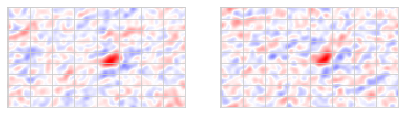

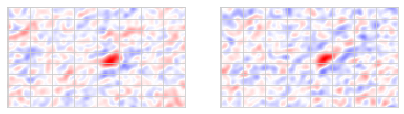

***** Group 61: ori range = [0.024 0.257], rf range = [-0.719 -0.478]


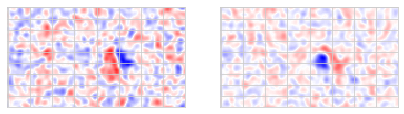

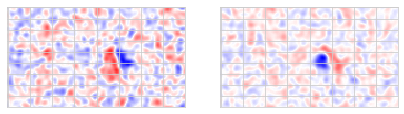

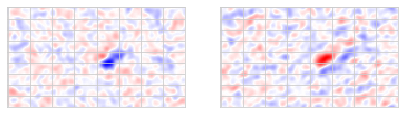

***** Group 62: ori range = [0.024 0.257], rf range = [-0.478 -0.354]
list was too samll so doing the length of the list which is 0
***** Group 63: ori range = [0.024 0.257], rf range = [-0.354 -0.192]
list was too samll so doing the length of the list which is 2


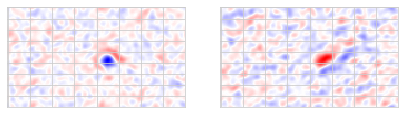

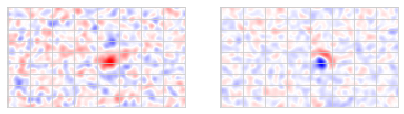

***** Group 64: ori range = [0.024 0.257], rf range = [-0.192 -0.089]
list was too samll so doing the length of the list which is 1


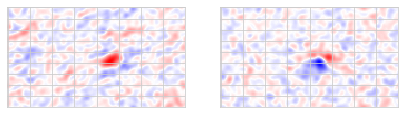

***** Group 65: ori range = [0.024 0.257], rf range = [-0.089  0.016]
list was too samll so doing the length of the list which is 1


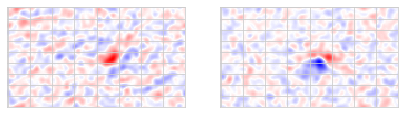

***** Group 66: ori range = [0.024 0.257], rf range = [0.016 0.077]
list was too samll so doing the length of the list which is 2


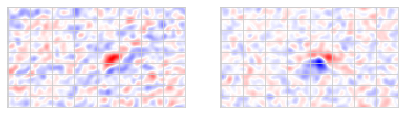

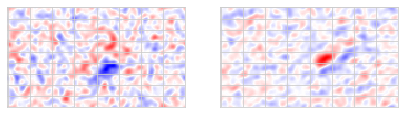

***** Group 67: ori range = [0.024 0.257], rf range = [0.077 0.249]
list was too samll so doing the length of the list which is 1


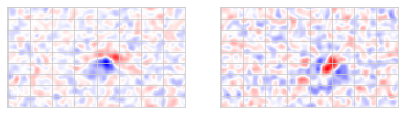

***** Group 68: ori range = [0.024 0.257], rf range = [0.249 0.393]


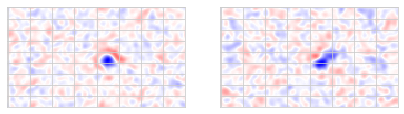

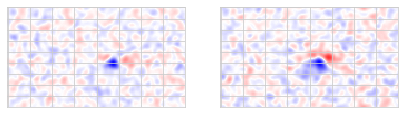

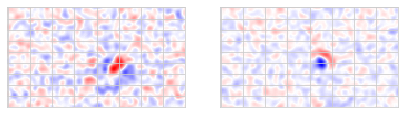

***** Group 69: ori range = [0.024 0.257], rf range = [0.393 0.556]
list was too samll so doing the length of the list which is 0
***** Group 70: ori range = [0.024 0.257], rf range = [0.556 0.829]


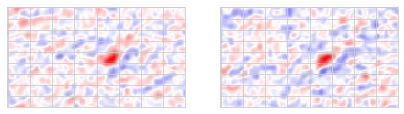

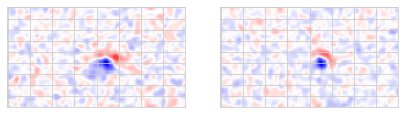

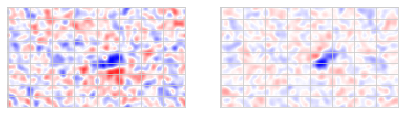

***** Group 71: ori range = [0.257 0.6  ], rf range = [-0.719 -0.478]
list was too samll so doing the length of the list which is 1


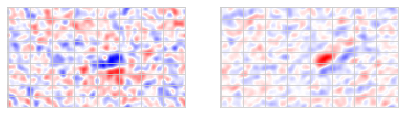

***** Group 72: ori range = [0.257 0.6  ], rf range = [-0.478 -0.354]


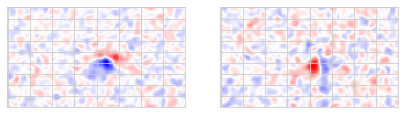

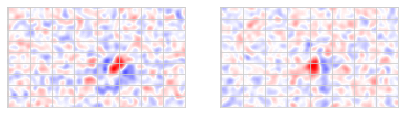

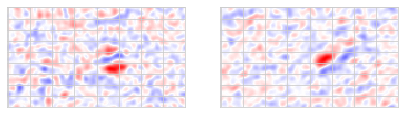

***** Group 73: ori range = [0.257 0.6  ], rf range = [-0.354 -0.192]
list was too samll so doing the length of the list which is 1


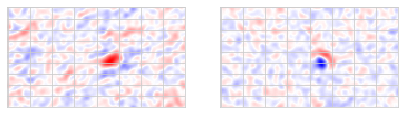

***** Group 74: ori range = [0.257 0.6  ], rf range = [-0.192 -0.089]


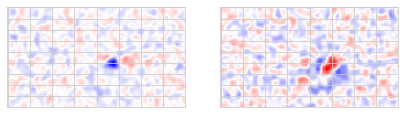

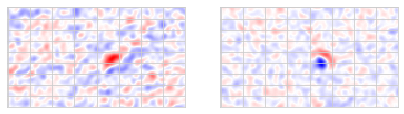

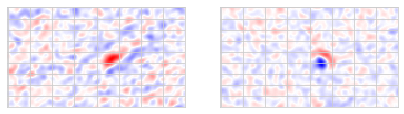

***** Group 75: ori range = [0.257 0.6  ], rf range = [-0.089  0.016]
list was too samll so doing the length of the list which is 1


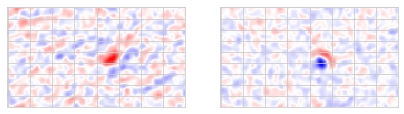

***** Group 76: ori range = [0.257 0.6  ], rf range = [0.016 0.077]
list was too samll so doing the length of the list which is 1


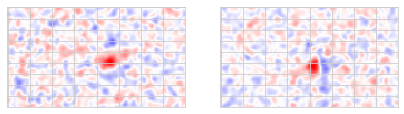

***** Group 77: ori range = [0.257 0.6  ], rf range = [0.077 0.249]
list was too samll so doing the length of the list which is 2


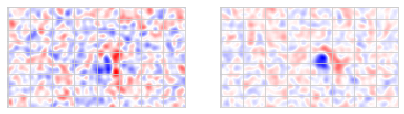

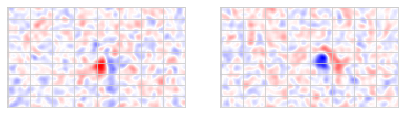

***** Group 78: ori range = [0.257 0.6  ], rf range = [0.249 0.393]
list was too samll so doing the length of the list which is 2


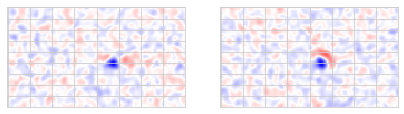

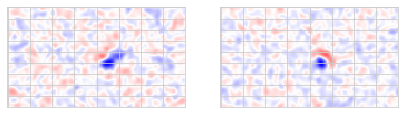

***** Group 79: ori range = [0.257 0.6  ], rf range = [0.393 0.556]
list was too samll so doing the length of the list which is 0
***** Group 80: ori range = [0.257 0.6  ], rf range = [0.556 0.829]
list was too samll so doing the length of the list which is 1


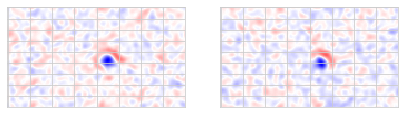

***** Group 81: ori range = [0.6   0.967], rf range = [-0.719 -0.478]
list was too samll so doing the length of the list which is 0
***** Group 82: ori range = [0.6   0.967], rf range = [-0.478 -0.354]
list was too samll so doing the length of the list which is 0
***** Group 83: ori range = [0.6   0.967], rf range = [-0.354 -0.192]
list was too samll so doing the length of the list which is 0
***** Group 84: ori range = [0.6   0.967], rf range = [-0.192 -0.089]
list was too samll so doing the length of the list which is 1


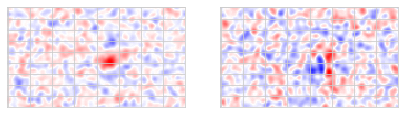

***** Group 85: ori range = [0.6   0.967], rf range = [-0.089  0.016]


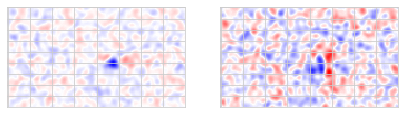

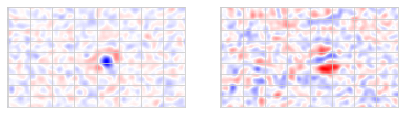

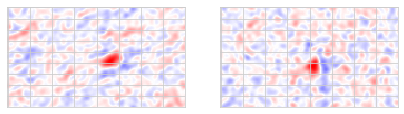

***** Group 86: ori range = [0.6   0.967], rf range = [0.016 0.077]


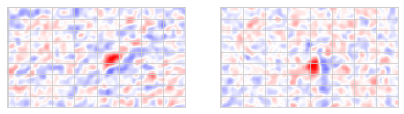

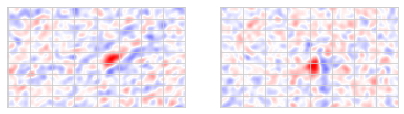

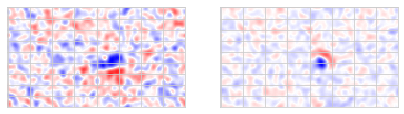

***** Group 87: ori range = [0.6   0.967], rf range = [0.077 0.249]


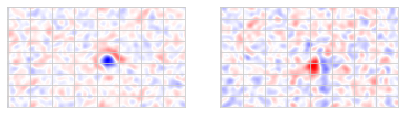

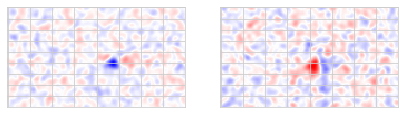

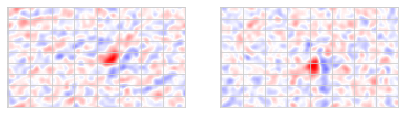

***** Group 88: ori range = [0.6   0.967], rf range = [0.249 0.393]
list was too samll so doing the length of the list which is 0
***** Group 89: ori range = [0.6   0.967], rf range = [0.393 0.556]
list was too samll so doing the length of the list which is 2


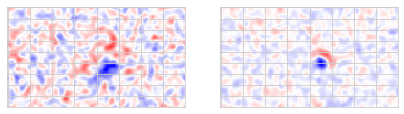

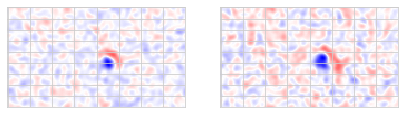

***** Group 90: ori range = [0.6   0.967], rf range = [0.556 0.829]
list was too samll so doing the length of the list which is 1


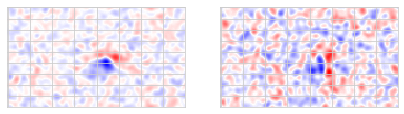

***** Group 91: ori range = [0.967 1.36 ], rf range = [-0.719 -0.478]


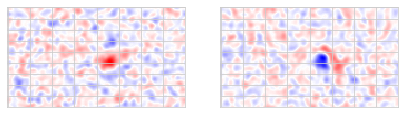

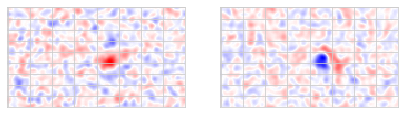

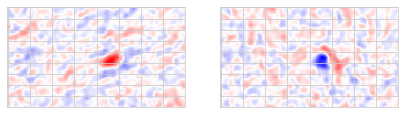

***** Group 92: ori range = [0.967 1.36 ], rf range = [-0.478 -0.354]
list was too samll so doing the length of the list which is 1


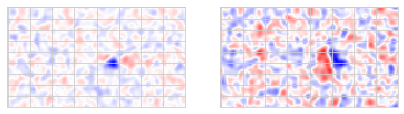

***** Group 93: ori range = [0.967 1.36 ], rf range = [-0.354 -0.192]
list was too samll so doing the length of the list which is 1


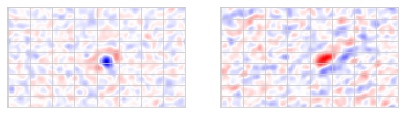

***** Group 94: ori range = [0.967 1.36 ], rf range = [-0.192 -0.089]
list was too samll so doing the length of the list which is 2


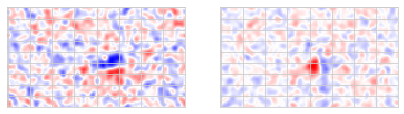

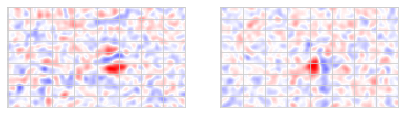

***** Group 95: ori range = [0.967 1.36 ], rf range = [-0.089  0.016]
list was too samll so doing the length of the list which is 1


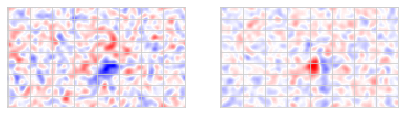

***** Group 96: ori range = [0.967 1.36 ], rf range = [0.016 0.077]
list was too samll so doing the length of the list which is 2


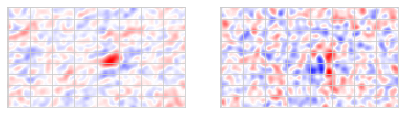

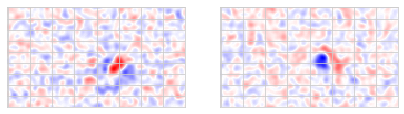

***** Group 97: ori range = [0.967 1.36 ], rf range = [0.077 0.249]
list was too samll so doing the length of the list which is 1


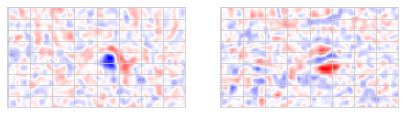

***** Group 98: ori range = [0.967 1.36 ], rf range = [0.249 0.393]


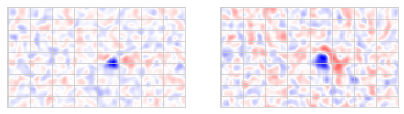

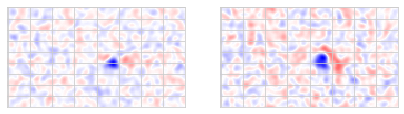

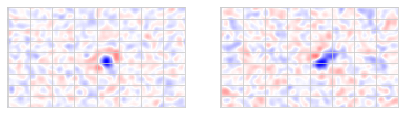

***** Group 99: ori range = [0.967 1.36 ], rf range = [0.393 0.556]
list was too samll so doing the length of the list which is 1


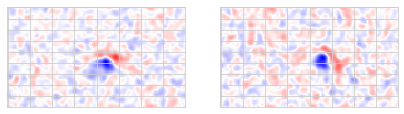

***** Group 100: ori range = [0.967 1.36 ], rf range = [0.556 0.829]
list was too samll so doing the length of the list which is 0


In [10]:
# Look that will go through and print out every figure
counter = 1
sample_per_bin = 3
for ori_index in range(0,len(ori_bin_edges)-1):
    for rf_index in range(0,len(rf_bin_edges)-1):
        ori_min_max = (ori_bin_edges[ori_index],ori_bin_edges[ori_index+1])
        
        rf_min_max = (rf_bin_edges[rf_index],rf_bin_edges[rf_index+1])
        
        #print the group showing rf values for
        print(f"***** Group {counter}: ori range = {np.round(ori_min_max,3)}, rf range = {np.round(rf_min_max,3)}")
        
        #restrict table by these values
        temp_cdf = cdf[(cdf.dori >ori_min_max[0] ) & (cdf.dori < ori_min_max[1] ) 
            & (cdf.rf_corr_coef >rf_min_max[0] ) & (cdf.rf_corr_coef < rf_min_max[1] )]
        
        if len(temp_cdf["segment_a"].values)>= sample_per_bin:
            segment_a_values = temp_cdf["segment_a"].values[:sample_per_bin]
            segment_b_values = temp_cdf["segment_b"].values[:sample_per_bin]
        else: 

            segment_a_values = temp_cdf["segment_a"].values
            segment_b_values = temp_cdf["segment_b"].values
            print("list was too samll so doing the length of the list which is " + str(len(segment_a_values)))
        
        for seg1,seg2 in zip(segment_a_values,segment_b_values):
            display_rf_field_groups(seg_group=[(seg1,seg2)])

        counter += 1